# Ejemplo de Large Language Model (LLM) InstructPix2Pix  para realizar ajustes en Imágenes usando órdenes en Texto

Fuente: https://huggingface.co/timbrooks/instruct-pix2pix

Otros ejemplos de prompt: https://learnopencv.com/instructpix2pix/

Otra opción: https://replicate.com/timothybrooks/instruct-pix2pix/examples

In [1]:
# @title Instalar librerías HuggingFace
!pip install diffusers accelerate safetensors transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 17.4 MB/s eta 0:00:00


In [2]:
#@title Cargar Librerías

import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import glob


import requests # request img from web
import shutil # save img locally
import tempfile

from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import Box, Layout
import glob

import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Librerías cargadas.")

print("Device: ", device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Librerías cargadas.
Device:  cpu


#Cargar Modelos

In [3]:
#@title Cargar Modelo

model_id = "timbrooks/instruct-pix2pix"
if torch.cuda.is_available():
  pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
  pipe.to("cuda")
else:
  pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float32, safety_checker=None)
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
#@title Define funciones auxiliares para ejecutar


# definicion iniciales

# ejemplos prompt
ejemplos_ordenes = [ "please improve the quality and resolution of the picture",
                    "Can you make it look stunning? like a professional photo",
                    "Retouch the picture as a professional photographer please",
                     "my image is too dark, I cannot see anything, can you fix it?",
                     "I love this photo, could you remove the raindrops? please keep the content intact",
                     "turn him into cyborg",
                     "Turn the humans into robots",
                      "add fireworks in the sky",
                     "make a 8bits video game please",
                      "turn into a still from a western",
                      "what should it look if it were snowing",
                      "what should it look if it were raining" ]



def downloadImage(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.resize((256,256), PIL.Image.LANCZOS)
    image = image.convert("RGB")
    return image


def plot_all (images, figsize=(20,10), axis='off', names=None):
    nplots = len(images)
    figsize = (figsize[0], figsize[1]*nplots)
    fig, axs = plt.subplots(nplots, 1, figsize=figsize, dpi=80, constrained_layout=True)
    for i in range(nplots):
        axs[i].imshow(images[i])
        if names: axs[i].set_title(names[i])
        axs[i].axis(axis)
    plt.show()


def process_img (image, prompt):
    images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
    return images[0]


def process(imageURL, promptList):
  # carga imagen
  image = downloadImage(imageURL)
  showList = [ image ]
  captionList= [ "Original" ]
  # procesa imagen
  for prompt in promptList:
    # procesa todos los ejemplos
    print("Procesando... (", prompt, ")", end=' ')
    restoredImage = process_img(image, prompt)
    print("- Finalizado.")
    # muestra resultados (hasta 3 imagenes generadas)
    showList.append( restoredImage )
    captionList.append( prompt )
  plot_all(showList, names=captionList, figsize=(20,10))



# para interfaces

def hacerNada():
  return


print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


# Ejecutar Modelo:

GridBox(children=(Text(value='https://www.greenpeace.org/static/planet4-argentina-stateless/2022/10/303ad760-g…

Procesando... ( Can you make it look stunning? like a professional photo ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.


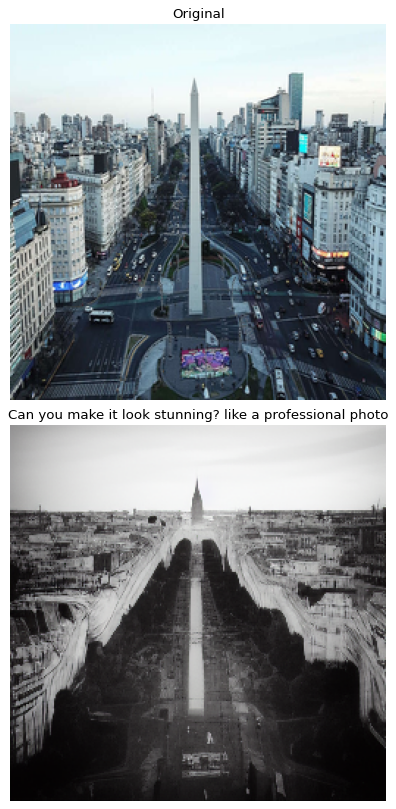

In [13]:
#@title Ejecutar usando imágenes de la web (selecciona prompt)


# se define esta función para que se ocupe de hacer el resfresco al tocar el botón solamente
def on_button_URL2_clicked(b):
  clear_output()
  display(pruebaURL_ui2)
  ut3D = widgets.interactive_output(hacerNada, {})
  # obtiene parámetros
  imgURL = imagText_URL2.value
  if (imgURL is None) and (imgURL != ""):
    return
  if promptOther_URL2.value != "":
    prompt = promptOther_URL2.value
  else:
    prompt = promptCombo_URL2.value
  # procesa
  process(imgURL, [prompt])


# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial', 'width': 'max-content'}

imagText_URL2 = widgets.Text(
    placeholder='Escribir URL de la imagen a procesar',
    description='Image URL:',
    value="https://www.greenpeace.org/static/planet4-argentina-stateless/2022/10/303ad760-gpa-reclamo-bosques-obelisco-2-1024x576.jpg",
    disabled=False
)

promptCombo_URL2 = widgets.Dropdown(
    options = ejemplos_ordenes,
    value = ejemplos_ordenes[0],
    description = 'Prompt a ejecutar:',
    style=style_3D,
    disabled = False,

)

promptOther_URL2 = widgets.Text(
    value='',
    placeholder='Escribir otro prompt en inglés',
    description='Other Prompt:',
    disabled=False
)

button_URL2 = widgets.Button(description="Ejecutar")
button_URL2.on_click(on_button_URL2_clicked)

# genera interface

pruebaURL_ui2 = widgets.GridBox(children=[imagText_URL2, promptCombo_URL2, promptOther_URL2, button_URL2],
        layout=Layout(
            width='100%',
            grid_template_rows='auto auto auto auto',
            grid_template_columns='100%',
        )
      )



display(pruebaURL_ui2)



GridBox(children=(Text(value='https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/examp…

Procesando... ( please inprove the quality and resolution of the picture ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( Can you make it look stunning? like a professional photo ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( Retouch the picture as a professional photographer please ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( my image is too dark, I cannot see anything, can you fix it? ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( I love this photo, could you remove the raindrops? please keep the content intact ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( turn him into cyborg ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( Turn the humans into robots ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( add fireworks in the sky ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( make a 8bits video game please ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( turn into a still from a western ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( what should it look if it were snowing ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.
Procesando... ( what should it look if it were raining ) 

  0%|          | 0/10 [00:00<?, ?it/s]

- Finalizado.


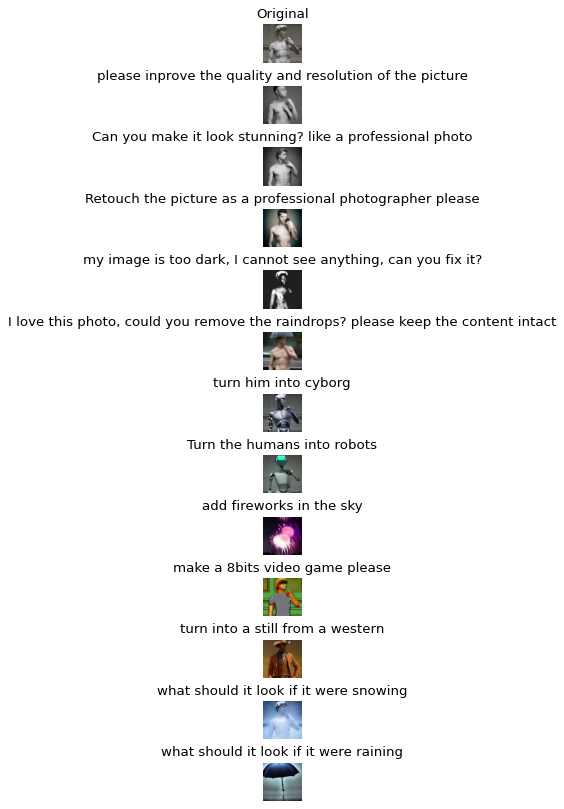

In [16]:
#@title Ejecutar usando imágenes de la web (todos los prompt de ejemplo)


# se define esta función para que se ocupe de hacer el resfresco al tocar el botón solamente
def on_button_URL_clicked(b):
  clear_output()
  display(pruebaURL_ui)
  ut3D = widgets.interactive_output(hacerNada, {})
  # obtiene parámetros
  imgURL = imagText_URL.value
  if (imgURL is None) and (imgURL != ""):
    return
  # procesa todos los prompts
  process(imgURL, ejemplos_ordenes)



# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial', 'width': 'max-content'}


imagText_URL = widgets.Text(
    placeholder='Escribir URL de la imagen a procesar',
    description='Image URL:',
    value="https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg",
    disabled=False
)

button_URL = widgets.Button(description="Ejecutar")
button_URL.on_click(on_button_URL_clicked)


pruebaURL_ui = widgets.GridBox(children=[imagText_URL, button_URL],
        layout=Layout(
            width='100%',
            grid_template_rows='auto auto auto auto',
            grid_template_columns='100%',
        )
      )


display(pruebaURL_ui)
